# Learning An Egocentric SBM Kernel for the UK

The aim of this notebook is to provide an end-to-end pipeline that learns an `EgocentricSBM` for the UK using egocentric surveys from Understanding Society, and the UK Census data.

## UK Census Microdata

In this section we look at the [microdata](https://census.ukdataservice.ac.uk/use-data/guides/microdata.aspx) available for UK Census 2011. In particular, the England-Wales dataset which has 2.8 million samples. We wish to look at key Blau dimensions of interest, so that we can align our own survey's design along with the census. Also, using microdata gives us the full testing distribution of the population, instead of one that is factorized over the Blau dimenions.

Different kinds of microdata have been made available (w/o a special license) corresponding to different geographical granularity. We consider the dataset at the local authority level (also referred to as boroughs in London, and council areas in Scotland). The dataset is available at a *grouped* LA level, wherein a few LAs can be grouped such that each grouped-LA contains roughly 120,000 people.

First, we write a function to import any census microdata file.

In [20]:
%matplotlib inline
import numpy as np

In [21]:
def import_data(name=('2011', 'ew'), memory_map=True, datapath='./census/'):
    import pandas as pd
    datadict = {(2001, 'isar'):'UKDA-7205-tab/tab/01uklicind-20061002.tab',
                (2001, 'sam'):'UKDA-7207-tab/tab/01uklicsam-20070301.tab',
                (2011, 'ew'):'UKDA-7682-tab/tab/recodev12.tab',
                (2011, 'n'):'UKDA-7770-tab/tab/ni_safeguarded_la.tab',
                (2011, 's'):'UKDA-7835-tab/tab/safeguarded_grouped_la.tab'
               }
    geogdict = {(2001, 'isar'):'region',
                (2001, 'sam'):'lacode',
                (2011, 'ew'):'la_group',
                (2011, 'n'):'LA_CODE_14',
                (2011, 's'):'COUNCIL_AREA_GROUP'
               }
    datapath += datadict[name]
    df = pd.read_csv(datapath, memory_map=memory_map, sep='\t')
    df.rename(columns={geogdict[name]:'geocode'}, inplace=True)
    return df

In [22]:
data_2011_ew = import_data((2011, 'ew'))
print(data_2011_ew.shape)

(2848149, 121)


## Understanding Society Data

We previously took a look at the Understanding Society data, and many of its variables of interest. In this notebook, we try to align USoc with the Census data, so that we can estimate the social access statistic for LAs. First, we import USoc data for wave 3, which has information on people's local social networks.

In [153]:
def import_usoc_data(category='ukhls', wave=3, survey='indresp', datapath='./usoc/'):
    datadict = {'ukhls':'UKDA-6614-tab/tab/ukhls_w', 
                'bhps':'UKDA-6614-tab/tab/bhps_w', 
                'nurse':'UKDA-7251-tab/tab/', 
                'ip':'UKDA-6849-tab/tab/'}
    from string import ascii_lowercase
    prefix = {'bhps':str(wave)+'/', 'ukhls':str(wave)+'/', 'nurse':'', 'ip':''}
    suffix = {'bhps':'', 'ukhls':'', 'nurse':'_ns', 'ip':'_ip'}
    wave_num2sym = {'bhps': dict(zip(range(1,19), ['b'+s+'_' for s in ascii_lowercase[0:18]])), 
                 'ukhls': dict(zip(range(1,8), [s+'_' for s in ascii_lowercase[0:7]])), 
                 'ip': dict(zip(range(1,11), [s+'_' for s in ascii_lowercase[0:10]])),
                 'nurse': {2:'b',3:'c'}}
    if isinstance(wave, int): wave_sym = wave_num2sym[category][wave]
    else: wave_sym = wave
    datapath = datapath + datadict[category] + prefix[category] + wave_sym + survey + suffix[category] + '.tab'
    from pandas import read_csv
    return {'cat':category, 'wav':wave, 'sym':wave_sym, 'svy':survey, 'tab':read_csv(datapath, sep='\t')}

In [154]:
data_wave3 = import_usoc_data(wave=3)

Next, we right functions that will extract and align the USoc and Census datasets.

In [155]:
def extract_usoc(data):
    import numpy as np
    from pandas import concat
    
    if data['cat']!='ukhls': 
        print('please use a ukhls dataset')
        return
             
    var = {'sex_dv':'sex',
           'netsx':'sex_nom',
           'age_dv':'age',
           'simage':'age_prop',
           'netag':'age_nom',
           'racel_dv':'ethnicity',
           'simrace':'ethnicity_prop',
           'netet':'ethnicity_nom',
           'qfhigh_dv':'education',
           'simeduc':'education_prop',
           'jbstat':'employment',
           'simjob':'employment_prop',
           'netjb':'employment_nom',
           'fimngrs_dv':'income',
           'siminc':'income_prop',
           'simarea':'distance_prop',
           'netlv':'distance_nom',
           'simfam':'family_prop',
           'closenum':'num_friends'
          }
    
    var_encoding = {'sex':{1:'male',
                           2:'female', 
                           (-10, -9, -8, -7, -2, -1, 0):np.nan},
                    'ethnicity':{1:'british-white', 
                                 (2, 3, 4):'other-white',
                                 (5, 6, 14, 15, 16):'black',
                                 (7, 8, 12, 13):'other-asian',
                                 (9, 10, 11):'south-asian',
                                 #11:'bangladeshi',
                                 #13:'other-asian',
                                 (17, 97):'other-ethnicity',
                                 (-10, -9, -8, -7, -2, -1):np.nan
                                },
                    'education':{(1, 2, 3, 4, 5, 6):'level-4',
                                 (7, 8, 9):'level-3',
                                 (10, 11, 12, 13):'level-2',
                                 (14, 15, 16):'level-1',
                                 96:'level-0',
                                 (-10, -9, -8, -7, -2, -1):np.nan
                                },
                    'employment':{(1, 2, 5, 10, 11, 97):'employed',
                                  3:'unemployed',
                                  4:'retired', 
                                  6:'housework', 
                                  (7, 9):'student',
                                  (8, -10, -9, -8, -7, -2, -1):np.nan
                                 },
                    'employment_nom':{(1, 2):'employed', 
                                      3:'unemployed', 
                                      4:'student',
                                      5:'housework', 
                                      6:'retired',
                                      (-10, -9, -8, -7, -2, -1):np.nan
                                     },
                    'distance_nom':{(1, 2):'similar', 
                                    (3, 4, 5):'dissimilar', 
                                    (-10, -9, -8, -7, -2, -1):np.nan
                                   }
                    }
    
    def expand_var(var_dict, prefix='', num_nom=3):
        new_dict = dict()
        for key, value in var_dict.items():
            if key[:3]=='net':
                for i in range(1, num_nom+1): new_dict[prefix+key+'_'+str(i)] = value+'_'+str(i)
            else: new_dict[prefix+key] = value
        return new_dict
    
    def expand_encoding(encoding_dict, atts=[], num_nom=3):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if not hasattr(k, '__iter__'): k = (k,)              
                for i in k: new_d[i] = v
            if key[-4:]=='_nom':
                for i in range(1, num_nom+1):
                    new_dict[key+'_'+str(i)] = new_d
            else:
                new_dict[key] = new_d
                if key in atts and key+'_nom' not in encoding_dict:
                    for i in range(1, num_nom+1):
                        new_dict[key+'_nom_'+str(i)] = new_d
        return new_dict
    
    def define_prop(x):
        if x==1: return 1
        elif x==2: return 3/4
        elif x==3: return 1/2
        elif x==4: return 1/4
        else: return np.nan
        
    def derive_prop(df, atts=[], num_nom=3):
        if not hasattr(atts, '__iter__'): atts = [atts]
        dfs = list()
        col = list()
        self_atts = set(df)
        for att in set(atts):
            if att in self_atts:
                idx = df[att].notnull()
                friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]][idx]
                dfs.append((friends.eq(df[att][idx], axis=0) & friends.notna()).sum(axis=1)/(friends.notna().sum(axis=1)))
            else:
                friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]]
                dfs.append(friends.eq('similar').sum(axis=1)/(friends.notna().sum(axis=1)))
            col.append(att+'_prop_dv')
        dfs = concat(dfs, axis=1)
        dfs.columns = col
        return dfs
    
    def classify_age(x, granularity=20):
        if np.isnan(x) or x < 16: return np.nan
        else: return min(x, 99)//granularity*granularity
        
    def classify_age_static(x): #http://www.pgagroup.com/standardized-survey-classifications.html
        if np.isnan(x) or x < 16: return np.nan
        elif 16 <= x < 25: return 20.0
        elif 25 <= x < 35: return 30.0
        elif 35 <= x < 45: return 40.0
        elif 45 <= x < 55: return 50.0
        elif 55 <= x < 65: return 60.0
        else: return 70.0
        
    def classify_income(x):
        if np.isnan(x): return np.nan
        elif x <= 584: return 'DE'
        elif x <= 1342: return 'C2'
        elif x <= 2115: return 'C1'
        else: return 'AB'
    
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = expand_var(var, prefix)
    out = data['tab'].loc[:,var.keys()]
    out.index = data['tab']['pidp']
    out.rename(columns=var, inplace=True)
    var_encoding = expand_encoding(var_encoding, atts=['sex', 'ethnicity'])
    out.replace(to_replace=var_encoding, inplace=True)
    out.loc[out['employment']=='unemployed','employment_prop'] = 1-out.loc[out['employment']=='unemployed','employment_prop'] 
    out['age_raw'] = out['age']
    #out['age'] = out['age'].apply(classify_age)
    out['age'] = out['age'].apply(classify_age_static)
    out['income_raw'] = out['income']
    out['income'] = out['income'].apply(classify_income)
    for i in range(1, 4):
        out['age_raw_nom_'+str(i)] = out['age_nom_'+str(i)]
        #out['age_nom_'+str(i)] = out['age_nom_'+str(i)].apply(classify_age)
        out['age_nom_'+str(i)] = out['age_nom_'+str(i)].apply(classify_age_static)
    for var_name in list(out):
        if var_name[-5:]=='_prop': out[var_name] = out[var_name].apply(define_prop)
    out[out._get_numeric_data()<0] = np.nan
    out = concat([out, derive_prop(out, atts=['sex', 'age', 'ethnicity', 'employment', 'distance'])], axis=1)
    out.dropna(axis=1, how='all', inplace=True)
    return out

In [156]:
data_wave3_atts = extract_usoc(data_wave3)

In [27]:
def extract_census(data):
    import numpy as np
    
    var = {'sex':'sex',
           'ageh':'age',
           'ethnicityew':'ethnicity',
           'hlqupuk11':'education',
           'ecopuk11':'employment',
           'scgpuk11c':'income',
           'religionew':'religion',
           'mainglangg':'language',
           'geocode':'geocode'
          }
    
    var_encoding = {'sex':{1:'male',
                           2:'female', 
                           -9:np.nan
                          },
                    'ethnicity':{1:'british-white', 
                                 (2, 3):'other-white',
                                 (4, 11, 12):'black',
                                 (5, 9, 10):'other-asian',
                                 (6, 7, 8):'south-asian',
                                 #8:'bangladeshi',
                                 #10:'other-asian',
                                 13:'other-ethnicity',
                                 -9:np.nan
                                },
                    'education':{10:'level-0',
                                 11:'level-1',
                                 (12, 13, 16):'level-2',
                                 14:'level-3',
                                 15:'level-4',
                                 -9:np.nan
                                },
                    'employment':{(1, 2, 3, 4, 7):'employed',
                                  (5, 6):'unemployed',
                                  (8, 9, 11):'student',
                                  10:'retired',
                                  12:'housework',
                                  (13, 14, -9):np.nan
                                 },
                    'income':{1:'AB',
                              2:'C1',
                              3:'C2',
                              4:'DE',
                              -9:np.nan
                             },
                    'religion':{1:'atheist',
                                2:'christian',
                                3:'buddhist',
                                4:'hindu',
                                5:'jewish',
                                6:'muslim',
                                7:'sikh',
                                8:'other-religion',
                                (9, -9):np.nan
                               },
                    'language':{1:'english/welsh',
                                2:'polish',
                                3:'punjabi',
                                4:'urdu',
                                5:'bengali',
                                6:'gujarati',
                                7:'arabic',
                                8:'french',
                                9:'other-language',
                                -9:np.nan
                               }
                   }
    
    def expand_encoding(encoding_dict):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if not hasattr(k, '__iter__'): k = (k,)              
                for i in k: new_d[i] = v
            new_dict[key] = new_d
        return new_dict
    
    def decode_age(x):
        return (x-0.5)*5
        
    def classify_age(x, granularity=20):
        if np.isnan(x) or x < 4: return np.nan
        else: return ((x-0.5)*5)//granularity*granularity
        
    def classify_age_static(x): #http://www.pgagroup.com/standardized-survey-classifications.html
        if np.isnan(x) or x < 16: return np.nan
        elif 16 <= x < 25: return 20.0
        elif 25 <= x < 35: return 30.0
        elif 35 <= x < 45: return 40.0
        elif 45 <= x < 55: return 50.0
        elif 55 <= x < 65: return 60.0
        else: return 70.0
    
    out = data.loc[:,var.keys()]
    out.rename(columns=var, inplace=True)
    var_encoding = expand_encoding(var_encoding)
    out.replace(to_replace=var_encoding, inplace=True)
    out['age_raw'] = out['age'].apply(decode_age)
    #out['age'] = out['age'].apply(classify_age)
    out['age'] = out['age_raw'].apply(classify_age_static)
    out[out._get_numeric_data()<0] = np.nan
    out.dropna(axis=1, how='all', inplace=True)
    return out

In [28]:
data_c2011_atts = extract_census(data_2011_ew)

## Generating SBM from USoc

Now that we have parsed and aligned USoc-Census data, we are ready to learn the SBM. $\rho$s are derived from prop-type questions for `education` and `income`, and from nominee-type questions using `nom2prop()` for `sex`, `age`, `ethnicity` and `employment`. The $\omega$s are derived from the response of the question "how many close friends do you have?" (discounting for family). And $\pi$s are derived from simple counts, **not from USoc but the census**, since the latter is more representative.

Given that the expected number of friends in an SBM follows Poisson distribution, and the number of friends within the same community follow a Binomial distribution, we can place appropriate conjugate prior distributions on $\omega$, $\rho$ and $\pi$ for every community. Namely, if there are $k$ communities, then $\forall i \in \{1,2,\dots k\}$:

$$\omega_i\sim\mathrm{Gamma}(\alpha_\omega,\beta_\omega)$$
$$\rho_i\sim\mathrm{Beta}(\alpha_\rho,\beta_\rho)$$
$$\boldsymbol\pi\sim\mathrm{Dirichlet}(\alpha_\pi, k)$$

Upon observing appropriate data for these parameters, we can update the priors appropriately. Let us observe dataset $\mathcal{D}$: $n_i$ people in community $i$, with number of friends $f_{i1},f_{i2},\dots,f_{in_i}$ within $i$ and $g_{i1},g_{i2},\dots,g_{in_i}$ outside of $i$. Then posterior distributions are given by:

$$\omega_i|\mathcal{D} \sim\mathrm{Gamma}\left(\alpha_\omega + \sum_{j=1}^{n_i}{(f_{ij}+g_{ij})},\beta_\omega + n_i\right)$$
$$\rho|\mathcal{D} \sim\mathrm{Beta}\left(\alpha_\rho + \sum_{j=1}^{n_i}{f_{ij}},\beta_\rho + \sum_{j=1}^{n_i}{g_{ij}}\right)$$
$$\boldsymbol\pi|\mathcal{D} \sim\mathrm{Dirichlet}\left(\{\alpha_\pi+n_1, \alpha_\pi+n_2, \dots \alpha_\pi+n_k\}, k \right)$$

We can use the mean/mode of the posteriors as the parameter to feed into the SBM, while the variance of the posteriors can inform us about the errors of the model. We demonstrate with a simple example below.

In [11]:
def posterior(priors={'pi':0.1, 'rho':(1.0, 1.0), 'omega':(3.0, 1.0)}, data={}, d=2, tol=1e-2, plot=False):
    from scipy.stats import beta, dirichlet, gamma
    import numpy as np
    rv, x = dict(), dict()
    data = data.copy()
    posteriors = dict()
    if data:
        if 'pi' in data:
            d = len(data['pi'])
            posteriors['pi'] = dirichlet(priors['pi'] + data['pi'])
        if 'rho' in data:
            a = data['rho'][0]
            b = data['rho'][1] - data['rho'][0]
            posteriors['rho'] = beta(priors['rho'][0] + a, priors['rho'][1] + b)
        if 'omega' in data:
            posteriors['omega'] = gamma(priors['omega'][0] + data['omega'].sum(), scale=1/(priors['omega'][1] + len(data['omega'])))
    #plot
    if plot:
        import matplotlib.pyplot as plt
        rv['pi'] = dirichlet(priors['pi']*np.ones(d))
        rv['rho'] = beta(priors['rho'][0], priors['rho'][1])
        rv['omega'] = gamma(priors['omega'][0], scale=1/priors['omega'][1])
        x['rho'] = np.linspace(tol, 1-tol, 100)
        max_omega = 3*priors['omega'][0]/priors['omega'][1]
        if 'omega' in posteriors: max_omega = max(max_omega, 3*posteriors['omega'].mean())
        x['omega'] = np.linspace(0, max_omega, 100)
        for i in x:
            plt.plot(x[i], rv[i].pdf(x[i]), label='prior of $\%s$'%i)
            if i in posteriors: plt.plot(x[i], posteriors[i].pdf(x[i]), label='posterior of $\%s$'%i)
            plt.legend()
            plt.show()
    if posteriors: return posteriors
    else: return rv

In [12]:
def generate_data(params={'pi':[0.5, 0.5], 'rho':0.5, 'omega':5}, n=100):
    from scipy.stats import multinomial, poisson, binom
    return {'pi': multinomial.rvs(n=n, p=params['pi']),
            'rho': (binom.rvs(n=n, p=params['rho']), n),
            'omega': poisson.rvs(params['omega'], size=n)}

In [13]:
data = generate_data({'pi':[0.2, 0.3, 0.5], 'rho':0.8, 'omega':5})

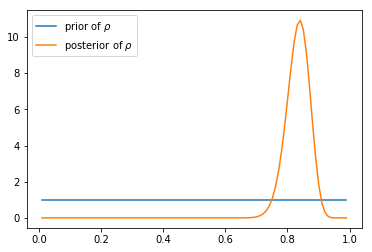

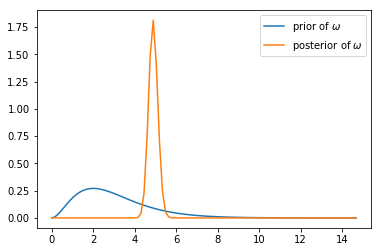

pi mean [0.2003988  0.33000997 0.46959123] var [0.00158183 0.00218266 0.00245879]
rho mean 0.8333333333333334 var 0.001348435814455232
omega mean 4.891089108910891 var 0.04842662484070189


In [15]:
param_posteriors = posterior(data=data, plot=True)
for k in param_posteriors: print(k, 'mean', param_posteriors[k].mean(), 'var', param_posteriors[k].var())

We thus recover the original parameters. We now do the same with actual data from USoc, learning parameters for every Blau dimensions separately.

In [418]:
def nom2prop(df, atts=['sex', 'age', 'ethnicity', 'employment', 'distance'], group=True, num_nom=3):
    if not hasattr(atts, '__iter__') or isinstance(atts, str): atts = [atts]
    dvs = dict()
    self_atts = set(df)
    for att in set(atts):
        if att in self_atts:
            if group:
                dvs[att] = dict()
                for name, data in df.groupby(att):
                    idx = data[att].notnull()
                    friends = data[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]][idx]
                    #dvs[att][name] = (friends.eq(data[att][idx], axis=0) & friends.notna()).sum(axis=1).sum()/friends.notna().sum(axis=1).sum()
                    rho_post = posterior(data={'rho':((friends.eq(data[att][idx], axis=0) & friends.notna()).sum(axis=1).sum(), friends.notna().sum(axis=1).sum())})
                    dvs[att][name] = (rho_post['rho'].mean(), rho_post['rho'].var())
            else:
                idx = df[att].notnull()
                friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]][idx]
                #dvs[att] = (friends.eq(df[att][idx], axis=0) & friends.notna()).sum(axis=1).sum()/friends.notna().sum(axis=1).sum()
                dvs[att] = (friends.eq(df[att][idx], axis=0) & friends.notna()).sum(axis=1).sum()/friends.notna().sum(axis=1).sum()
        else:
            friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]]
            dvs[att] = friends.eq('similar').sum(axis=1).sum()/friends.notna().sum(axis=1).sum()
    return dvs    

In [508]:
def generate_sbm_params(df, df_pi=None, prop=['education', 'income'], prop_dv=[], prop_dv_global=['sex', 'age', 'ethnicity', 'employment'], ignore_family=True, plot=False, save='', fmt='.pdf', fontsize=6):
    if df_pi is None: df_pi = df
    all_atts = list(df)
    prop = dict([(i, i+'_prop') for i in prop if i in all_atts and i+'_prop' in all_atts])
    prop_dv = dict([(i, i+'_prop_dv') for i in prop_dv if i not in prop and i in all_atts and i+'_prop_dv' in all_atts])
    print('using prop for dims:', set(prop.keys()))
    print('using prop-dv for dims:', set(prop_dv.keys()))
    prop.update(prop_dv)
    prop_dv_global = set([i for i in prop_dv_global if i not in prop and i in all_atts and i+'_nom_1' in all_atts])
    print('using prop-dv-global for dims:', prop_dv_global)
    prop_dv_global = nom2prop(df, prop_dv_global)
    dimnames = []
    pis = []
    rhos = []
    omegas = []
    #meanomegas = []
    for dim in list(prop.keys())+list(prop_dv_global.keys()):
        df_given_dim = df.groupby(dim)
        names = []
        pi = []
        rho = []
        omega = []
        #tot = 0
        for name, data in df_given_dim:
            names.append(name)
            pi.append(df_pi[df_pi[dim]==name].size)
            if dim in prop:
                rho_data = data[prop[dim]].values
                rho_data = rho_data[~np.isnan(rho_data)]
                rho_post = posterior(data={'rho':(rho_data.sum(), len(rho_data))})
                rho.append((rho_post['rho'].mean(), rho_post['rho'].var()))
            else: rho.append(prop_dv_global[dim][name])
            if ignore_family: om_data = data['num_friends']*(1-data['family_prop']).values
            else: om_data = data['num_friends'].values
            om_data = om_data[~np.isnan(om_data)]
            om_post = posterior(data={'omega':om_data})
            omega.append((om_post['omega'].mean(), om_post['omega'].var()))
            #tot += pi[-1]
        #pi = [p/tot for p in pi]
        pi_post = posterior(data={'pi':np.array(pi)})
        dimnames.append((dim, names))
        pis.append((pi_post['pi'].mean(), pi_post['pi'].var()))
        rhos.append(rho)
        omegas.append(omega)            
        #meanomegas.append(sum([(o*p) for o,p in zip(omega, pi)]))
    if plot:
        import matplotlib.pyplot as plt
        plt.figure(dpi=120)
        for i in range(len(dimnames)):
            for j in range(len(dimnames[i][1])): plt.errorbar(i, pis[i][0][j], yerr=pis[i][1][j], fmt='o', label=dimnames[i][1][j])
        plt.title('pi')
        plt.xticks(np.arange(len(dimnames)), [d[0] for d in dimnames])
        plt.legend(bbox_to_anchor=(1.02,1.0), loc='upper left', prop={'size':fontsize})
        if save: plt.savefig(save+'/param_pi'+fmt, bbox_inches='tight')
        plt.show()
        plt.figure(dpi=120)
        for i in range(len(dimnames)):
            for j in range(len(dimnames[i][1])): plt.errorbar(i, rhos[i][j][0], yerr=rhos[i][j][1], fmt='o', label=dimnames[i][1][j])
        plt.title('rho')
        plt.xticks(np.arange(len(dimnames)), [d[0] for d in dimnames])
        plt.legend(bbox_to_anchor=(1.02,1.0), loc='upper left', prop={'size':fontsize})
        if save: plt.savefig(save+'/param_rho'+fmt, bbox_inches='tight')
        plt.show()
        plt.figure(dpi=120)
        for i in range(len(dimnames)):
            for j in range(len(dimnames[i][1])): plt.errorbar(i, omegas[i][j][0], yerr=omegas[i][j][1], fmt='o', label=dimnames[i][1][j])
        plt.title('omega')
        plt.xticks(np.arange(len(dimnames)), [d[0] for d in dimnames])
        plt.legend(bbox_to_anchor=(1.02,1.0), loc='upper left', prop={'size':fontsize})
        if save: plt.savefig(save+'/param_omega'+fmt, bbox_inches='tight')
        plt.show()
    #mo = sum(meanomegas)/len(meanomegas)
    #print('mean omega', mo)
    #for i in range(len(omegas)):
    #    for j in range(len(omegas[i])):
    #        omegas[i][j] *= mo/meanomegas[i] #a *small* correction to ensure mean omega is same across all dimensions
    return {'shape':[len(i) for i in pis], 'name':dimnames, 'pi':pis, 'rho':rhos, 'omega':omegas}    

using prop for dims: {'education', 'income'}
using prop-dv for dims: set()
using prop-dv-global for dims: {'age', 'ethnicity', 'sex', 'employment'}


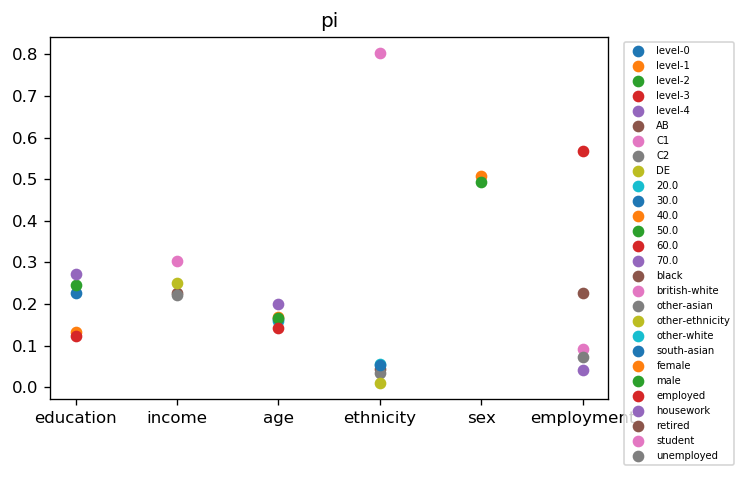

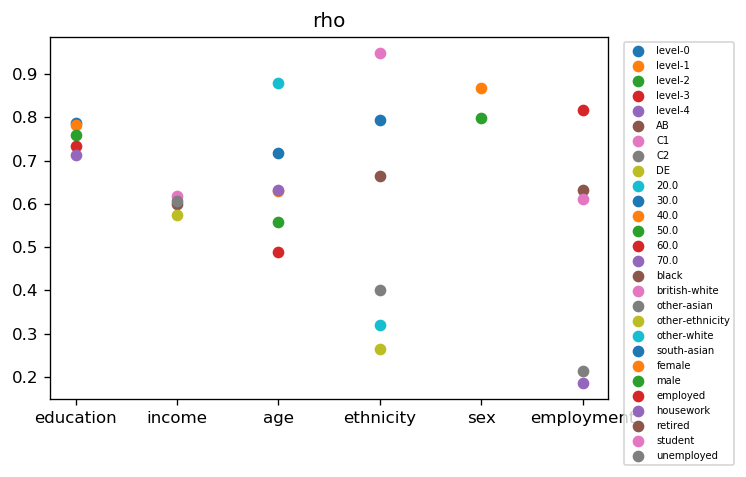

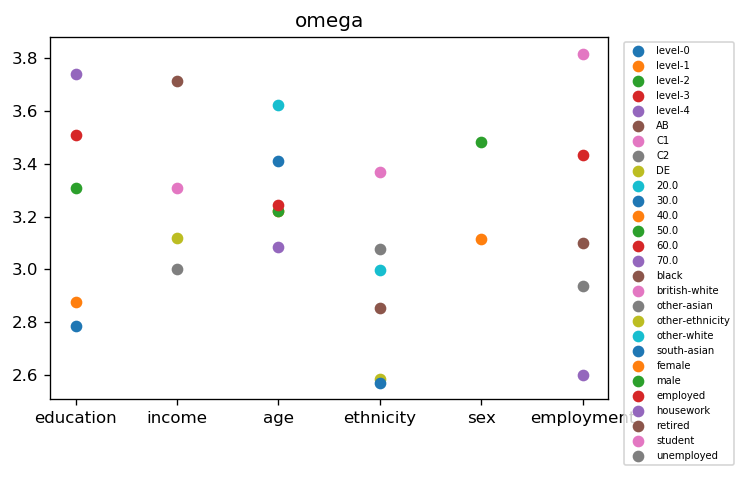

In [509]:
sbm_params = generate_sbm_params(data_wave3_atts, data_c2011_atts, plot=True)

We note the following:

1. We note a monotonicity in $\rho$ for the education and age dimensions. Indeed, $\rho$ is higher for lesser educated and younger people. This seems to align well with Smith 2014's observation trends of homophily in the US.
2. We note interesting trends in $\omega$ across all Blau dimensions: people who are better educated, richer, younger and from a majority ethnicity have more number of friends on average. For employment too, we note students have the highest $\omega$, followed by employed, retired, unemployed, and houseworkers.
3. The posterior variances are negligible (the error bars are practically invisible in the above plots), which is assuring. However, we did use weak priors.

So we can now simply import the `EgocentricSBM` class and explore the learnt SBM. (See the egosbm notebook for more details on this class.)

## Continuous Dimensions
We also note that at least 3 of these dimensions are ordinal: age, education, and income. For these dimensions, the EDA assumption (the community discriminate against all other communities equally) may not hold, but an ordinal smooth kernel which favours people "closer" on the dimension may enjoy a higher propensity than those further away. We can infer the said exponential kernel even from proportion-type data: "what proportion of your friends are within a window $w$ of you along dimension X?" (See the cont2cat notebook for more details.)

In [17]:
def func_theta(theta, window=0, rho=0):
    import numpy as np
    def f(x, y=0): return (x**(2-2*y)*(2*x**y-1)**2 + x**(2*y)*(2*x**(1-y)-1)**2 + 2*x*(1-2*x))/(1-x)**2
    def g(x, y=0): return (1-x)**0.5/(1+(x**(1-y)-x**y)/(2*(x**(y-1)-1)))
    a = np.exp(-theta)
    b = np.exp(theta)
    logterm = f(a, window)
    arctanh = g(b, window)
    return window + (1/(2*theta))*np.log(logterm) + ((b**window-1)/(2*theta*(1-b)**0.5))*np.log((1+arctanh)/(1-arctanh)) - rho

In [19]:
def plot_contour(func, domain=((0,1),(0,1)), args=False, n=1000, aspect='auto', xlabel='', ylabel='', zlabel='', colorbar=True, refresh=False, levels=None, save='', fmt='.pdf'):
    import numpy as np
    import matplotlib.pyplot as plt
    if isinstance(domain, dict):
        x = np.linspace(domain['x'][0], domain['x'][1], n)
        y = np.linspace(domain['y'][0], domain['y'][1], n)
    else:
        x = np.linspace(domain[0][0], domain[0][1], n)
        y = np.linspace(domain[1][0], domain[1][1], n)
    xx, yy = np.meshgrid(x, y, sparse=True)
    if args: z = func(xx, yy, args)
    else: z = func(xx, yy)
    h = plt.axes(aspect=aspect)
    if levels is None: plt.contourf(x, y, z)
    else: plt.contourf(x, y, z, levels=levels)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if colorbar:
        if zlabel: plt.colorbar(label=zlabel)
        else: plt.colorbar()
    if save: plt.savefig(save+xlabel+'_vs_'+ylabel+'_vs_'+zlabel+fmt, bbox_inches = 'tight')
    elif refresh: plt.show()

Below, we plot how $\rho$ (proportion of friends within $w$) varies as the homophily is made stronger (more negative $\theta$) or as the window of query $w$ increases.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


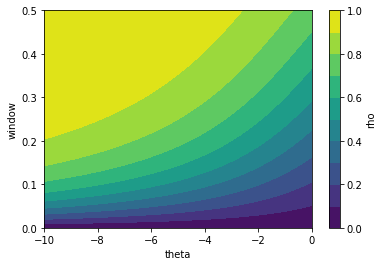

In [20]:
plot_contour(func_theta, ((-10,0),(0,0.5)), xlabel='theta', ylabel='window', zlabel='rho', levels=np.linspace(0, 1, 11))

The contour plot makes it clear that $\rho$ monotonically increases with the window $w$ (for a given $\theta$) and with homophily $-\theta$ (for a given $w$). Now if we know $w$ and $\rho$, we can solve for $\theta$. However, USoc survey does not ask questions at a quantitative window $w$, instead going for "what proportion of your friends have a similar X as you?"

However, because we are using nominee type questions converted to prop-type questions for age, and because we know the distribution of people along income and education, we can assume people too treat others as being "similar" based on these categories. Under this assumption, we can use the exponential kernel characterization to infer a $\theta$ that satisfies that $\rho$ for the category-windows we have determined to be appropriate.

For a quick analysis, we will assume equiproportioned population across our dimensions of interest.

In [663]:
def solve_theta_window(rho, window, init=-1):
    from scipy.optimize import fsolve as solve
    if hasattr(rho, '__iter__'): return [solve_theta(r, window, init) for r in rho]
    assert(window<=0.5)
    assert(init<0)
    assert(0<rho<1)
    return solve(func_theta, init, (window, rho))[0]

In [686]:
def solve_theta_self(rho, boundaries=None, init=-1):
    from scipy.optimize import fsolve as solve
    from numpy import exp, log
    def f_rho_self(c, a, b, val=0.):
        try:
            if all(a==b): return a-a
        except: pass
        logterm = (exp(2*c*(1-b))-2*exp(c*(1-b))+exp(c))/(exp(2*c*(1-a))-2*exp(c*(1-a))+exp(c))
        arctanh = ((exp(c*a)-exp(c*b))*(1-exp(c))**0.5)/(exp(c)+exp(c*(a+b))-exp(c*a)-exp(c*b))
        return exp(-c*a) + (exp(-c*a)-exp(-c*(1-b)))/(2*c*(b-a))*log(logterm) - (exp(-c*a)+exp(-c*(1-b))-2)/(2*c*(1-exp(c))**0.5*(b-a))*log((1+arctanh)/(1-arctanh)) - val
    
    if boundaries is None: boundaries = np.linspace(0, 1, len(rho)+1)
    assert(boundaries[0]==0)
    assert(boundaries[-1]==1)
    assert(len(rho)==len(boundaries)-1)
    solutions = []
    for i in range(len(rho)): solutions.append(solve(f_rho_self, init, (boundaries[i], boundaries[i+1], rho[i]))[0])
    return solutions

In [709]:
def func_rho(theta, k=4, boundaries=None):
    from numpy import exp, log
    
    def f_rho_self(c, a, b):
        try:
            if all(a==b): return a-a
        except: pass
        logterm = (exp(2*c*(1-b))-2*exp(c*(1-b))+exp(c))/(exp(2*c*(1-a))-2*exp(c*(1-a))+exp(c))
        arctanh = ((exp(c*a)-exp(c*b))*(1-exp(c))**0.5)/(exp(c)+exp(c*(a+b))-exp(c*a)-exp(c*b))
        return exp(-c*a) + (exp(-c*a)-exp(-c*(1-b)))/(2*c*(b-a))*log(logterm) - (exp(-c*a)+exp(-c*(1-b))-2)/(2*c*(1-exp(c))**0.5*(b-a))*log((1+arctanh)/(1-arctanh))
    
    def f_rho_low(c, a, b, p, q):
        try:
            if all(a==b): return a/a
            elif all(p==q): return p-p
        except: pass
        logterm = (exp(2*c*(1-b))-2*exp(c*(1-b))+exp(c))/(exp(2*c*(1-a))-2*exp(c*(1-a))+exp(c))
        arctanh = ((exp(c*a)-exp(c*b))*(1-exp(c))**0.5)/(exp(c)+exp(c*(a+b))-exp(c*a)-exp(c*b))
        return (exp(-c*q)-exp(-c*p))/(2*c*(b-a))*(-2*c*(b-a) - log(logterm) + 1/(1-exp(c))**0.5*log((1+arctanh)/(1-arctanh)))
    
    def f_rho_high(c, a, b, p, q):
        try:
            if all(a==b): return a/a
            elif all(p==q): return p-p
        except: pass
        logterm = (exp(2*c*(1-b))-2*exp(c*(1-b))+exp(c))/(exp(2*c*(1-a))-2*exp(c*(1-a))+exp(c))
        arctanh = ((exp(c*a)-exp(c*b))*(1-exp(c))**0.5)/(exp(c)+exp(c*(a+b))-exp(c*a)-exp(c*b))
        return (exp(-c*(1-p))-exp(-c*(1-q)))/(2*c*(b-a))*(log(logterm)+1/(1-exp(c))**0.5*log((1+arctanh)/(1-arctanh)))
    
    if isinstance(theta, int) or isinstance(theta, float):
        if boundaries is None: theta = theta*np.ones(k)
        else: theta = theta*np.ones(len(boundaries)-1)
    if boundaries is None: boundaries = np.linspace(0, 1, len(theta)+1)
    assert(boundaries[0]==0)
    assert(boundaries[-1]==1)
    assert(len(theta)==len(boundaries)-1)
    rho_mat = []
    for i in range(len(boundaries)-1):
        rhos = []
        a, b = boundaries[i], boundaries[i+1]
        for j in range(i):
            p, q = boundaries[j], boundaries[j+1]
            rhos.append(f_rho_low(theta[i], a, b, p, q))
        rhos.append(f_rho_self(theta[i], a, b))
        for j in range(i+1, len(boundaries)-1):
            p, q = boundaries[j], boundaries[j+1]
            rhos.append(f_rho_high(theta[i], a, b, p, q))
        rho_mat.append(rhos)
    return np.array(rho_mat)

In [694]:
def plot_matrix(matrix, labels=False, title='', save='', fmt='.pdf'):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(dpi=120)
    ax = sns.heatmap(matrix, square=True, cmap='Spectral', xticklabels=labels, yticklabels=labels)
    if title: plt.title(title)
    if save: plt.savefig(save+title+fmt, bbox_inches='tight')
    else: plt.show()

Now we use the $\rho$s inferred above from USoc, and apply the exponential kernel setup to infer $\theta$s for every block of the Blau dimension, and correspondingly the proportion of friends a community will have across the entire Blau dimension. Let's do this for age first.

rho age: [0.8795737122557726, 0.7168223720843903, 0.6294147582697202, 0.5571218949795619, 0.4888313982836951, 0.6322679175302717]
theta age (inferred): [-25.43643367737479, -20.217316373274414, -14.774885140955782, -11.462509542541532, -8.173592046656891, -8.036897889800269]
rho age (inferred): [0.8795737  0.71682237 0.62941476 0.55712189 0.4888314  0.63226792]


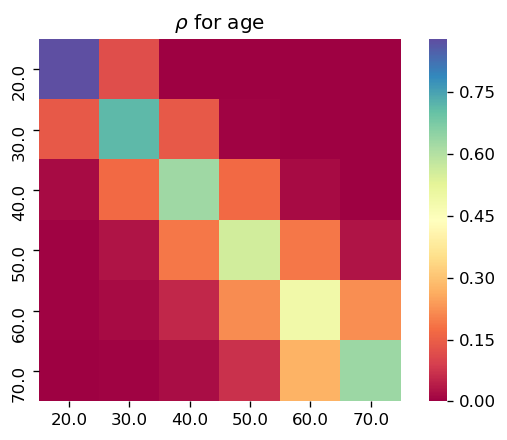

In [703]:
rho_age = [i[0] for i in sbm_params['rho'][2]]
theta_age = solve_theta_self(rho_age)
rho_all_age = func_rho(theta_age)
print('rho age:', rho_age)
print('theta age (inferred):', theta_age)
print('rho age (inferred):', np.diag(rho_all_age))
plot_matrix(rho_all_age, sbm_params['name'][2][1], title='$\\rho$ for age')

Things to note:
1. Clearly, $\theta$ increases perfectly monotonically with age, strengthening the idea that homophily is stronger in younger people.
2. Although $\rho$ for age group 70 itself is quite high (compared to say 50 or 60 year olds, which broke the monotonicity), its $\theta$ is the smallest. This observation neatly captures the edge effect which was previously missing from our analysis, that is, people at the edges of the Blau dimension will have a higher $\rho$ than those in the bulk, even for the same $\theta$, by the virtue of being positioned at the edge. This becomes more obvious when we look at the matrix of $\rho$s for all pairs of ages.

We repeat this analysis for income groups (or employment-type groups).

rho inc: [0.5988417554491252, 0.6181683899556869, 0.6073896518960007, 0.5743704401035538]
theta inc (inferred): [-4.659429871873838, -9.060005101766219, -8.680419488906448, -4.243070605874064]
rho inc (inferred): [0.59884176 0.61816839 0.60738965 0.57437044]


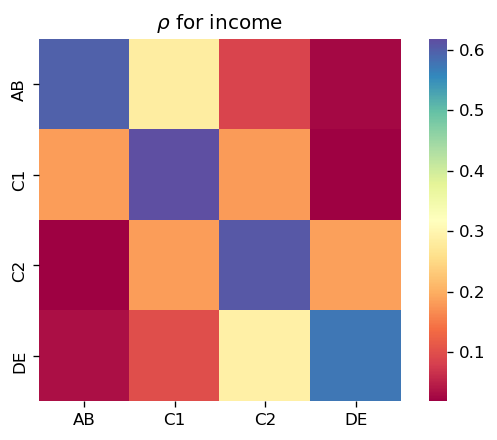

In [702]:
rho_inc = [i[0] for i in sbm_params['rho'][1]]
theta_inc = solve_theta_self(rho_inc)
rho_all_inc = func_rho(theta_inc)
print('rho inc:', rho_inc)
print('theta inc (inferred):', theta_inc)
print('rho inc (inferred):', np.diag(rho_all_inc))
plot_matrix(rho_all_inc, sbm_params['name'][1][1], title='$\\rho$ for income')

Again, although the $\rho$s are all quite comparable, the bulk is much more homophilous than the edges. This adds more credulity to the exponential kernel assumption, over the EDA one.

rho edu: [0.7873970345963757, 0.7829450309428467, 0.7601093801789858, 0.7342526109660574, 0.7125576986482031]
theta edu (inferred): [-12.31575224190963, -22.701746543767943, -20.49290465808315, -18.145701618263384, -8.983709612312476]
rho edu (inferred): [0.78739703 0.78294503 0.76010938 0.73425261 0.7125577 ]


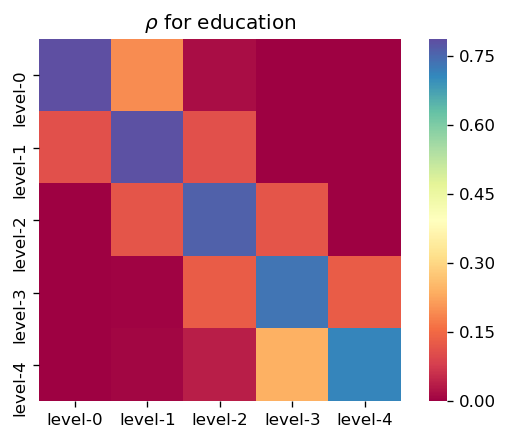

In [701]:
rho_edu = [i[0] for i in sbm_params['rho'][0]]
theta_edu = solve_theta_self(rho_edu)
rho_all_edu = func_rho(theta_edu)
print('rho edu:', rho_edu)
print('theta edu (inferred):', theta_edu)
print('rho edu (inferred):', np.diag(rho_all_edu))
plot_matrix(rho_all_edu, sbm_params['name'][0][1], title='$\\rho$ for education')

Additionally, once we have inferred $\theta$, it leaves us free to change the number of blocks in our analysis, allowing us to move from discrete to near-continuous settings, as evidenced by the plots below. We assume the same $\theta$ for all blocks.

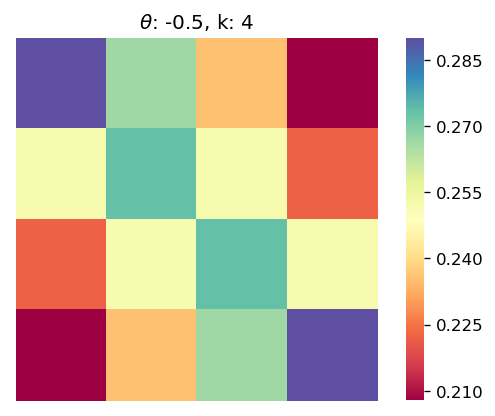

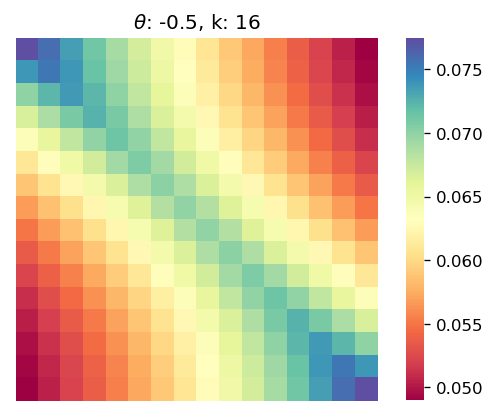

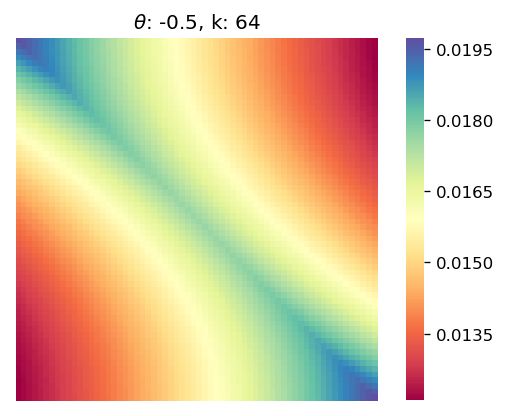

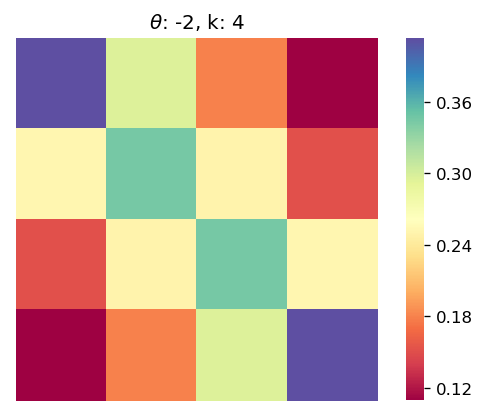

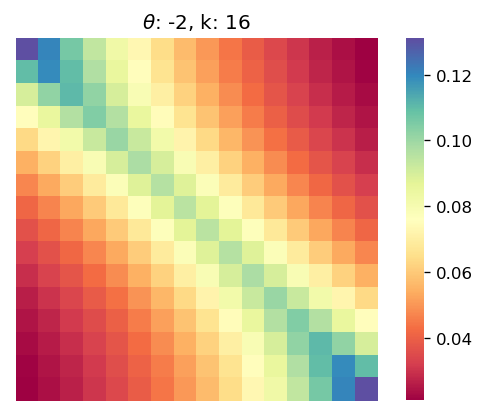

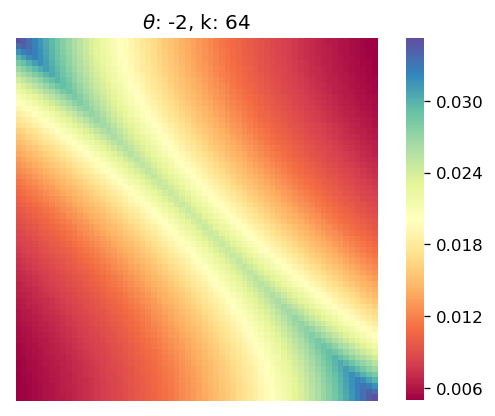

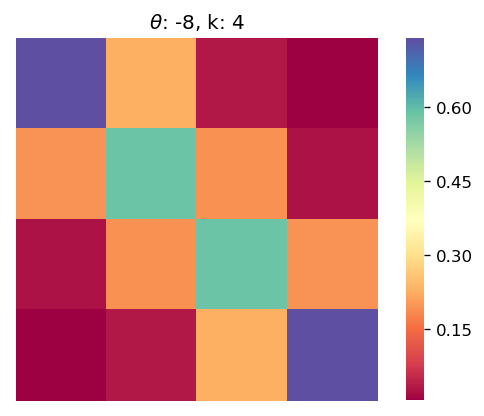

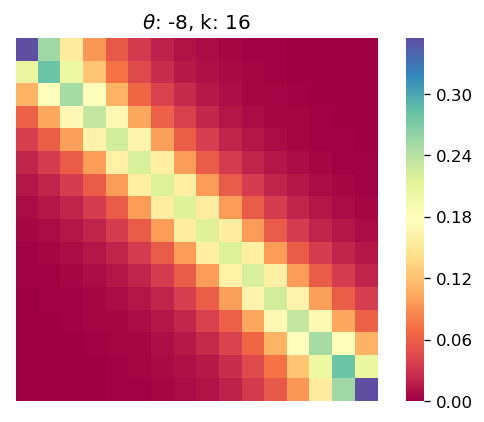

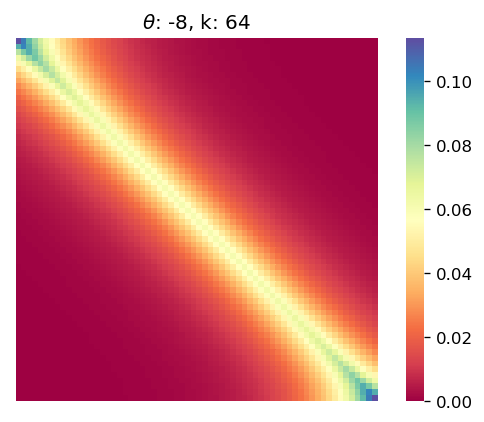

In [711]:
for theta in [-0.5, -2, -8]:
    for k in [4, 16, 64]:
        plot_matrix(func_rho(theta, k), title='$\\theta$: '+str(theta)+', k: '+str(k))

Again, the edge effects are much more visible as we increase the number of blocks. Another place where this becomes apparent is in the asymmetry of the matrix--- proportion of friends in a certain block will not be identically reciprocated by another block, even if they have the same $\theta$, owing to the edge effects in ordinal dimensions.